### Overview 

Objective :

- Build a model for detecting anomalies

Motivation :

- Autoencoders are neural networks that can learn the underlying structure of data and identify deviations from that structure.
- They can be useful for anomaly detection because they learn to encode input data into a lower-dimensional representation and then decode it back into the original input space. 
- When an autoencoder is trained on normal data, it learns to reconstruct that data with low error. So, when presented with anomalous data, the reconstruction error will be higher, indicating that the data is anomalous. 
- Autoencoders can also detect anomalies without requiring labeled training data.

Dataset : 
- ECG dataset is used model training to detect abnormalities in ECG signals.

Sources :
- https://www.tensorflow.org/tutorials/generative/autoencoder#build_the_model
- https://www.timeseriesclassification.com/description.php?Dataset=ECG5000

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

<td>
<a target="_blank" href="https://colab.research.google.com/github/amdhiqal/ML/blob/main/Deep%20Learning/AutoEncoder%20for%20Detecting%20Anomalies%20(PyTorch)/1.%20AutoEncoder_ECG_PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

### Data

- ECG dataset is a collection of heart signals used for detecting heart problems. It shows the records of the electrical activity of the heart over time.


In [2]:
### data source

# !wget http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv

In [3]:
# path = "AutoEncoder_ECG_PyTorch.csv"
# d = pd.read_csv(path, header = None)

In [4]:
d = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
d.head(5)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
### missing values check

print(d.isnull().values.any())

False


- 2 categories, '1' is normal and '0' is abnormal.

In [6]:
d_count =  d[140].value_counts().sort_index()
d_count

0.0    2079
1.0    2919
Name: 140, dtype: int64

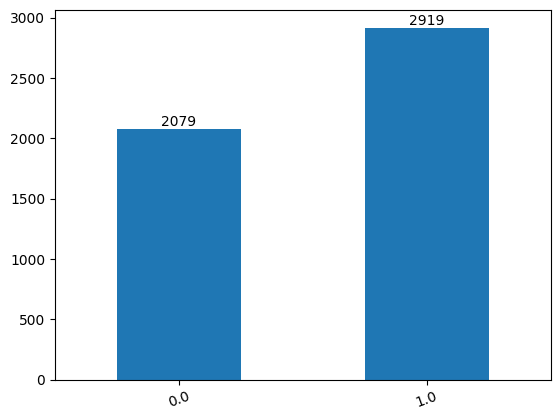

In [7]:
d_count.plot.bar()

for i, count in enumerate(d_count):
    plt.text(i, count, str(count), ha = 'center', va = 'bottom')
    # d_count.plot.bar().text(i, count, str(count), ha = 'center', va = 'bottom')

plt.xticks(rotation = 20)
plt.show()

In [8]:
raw_data = d.astype('float32').values 

In [9]:
data = torch.Tensor(raw_data[:, 0:-1])
# data = torch.from_numpy(raw_data[:, 0:-1])

data.shape

torch.Size([4998, 140])

In [10]:
type(data)

torch.Tensor

In [11]:
labels = torch.Tensor(raw_data[:, -1])
labels.shape

torch.Size([4998])

In [12]:
# data[:1]

In [13]:
# labels[:5]

In [14]:
### a random state for reproducible purpose

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.4, random_state = 42)

In [15]:
min_val = torch.min(train_data)
max_val = torch.max(train_data)

In [16]:
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

In [17]:
train_data = train_data.to(torch.float32)
test_data = test_data.to(torch.float32)

In [18]:
train_labels = train_labels.to(torch.bool)
test_labels = test_labels.to(torch.bool)

In [19]:
# train_data[:1]

In [20]:
### normal data is used for model (AutoEncoder) training

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

#### Using DataLoader

In [21]:
train_set_0 = TensorDataset(normal_train_data, torch.ones(len(normal_train_data)))
val_set_0 = TensorDataset(normal_test_data, torch.ones(len(normal_test_data)))

train_dataloader = DataLoader(train_set_0, 512, shuffle = True)
val_dataloader = DataLoader(val_set_0, 512)

### Plot

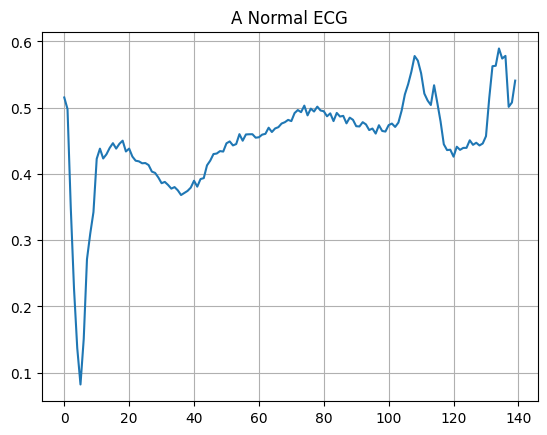

In [22]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

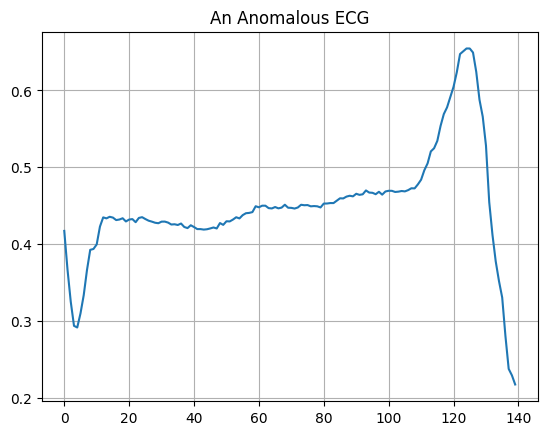

In [23]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Model

In [24]:
class AutoEncoder(nn.Module):
    '''
    AutoEncoder for anomalies detection.
    Details of Encoder-Decoder architecture.

    Return: reconstruction of data.
    '''

    def __init__(self):
        super().__init__()

        self.encoder_ = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.ReLU()
        )

        self.decoder_ = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 140),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder_(x)
        decoded = self.decoder_(encoded)

        return decoded   

In [25]:
autoencoder = AutoEncoder()
autoencoder

AutoEncoder(
  (encoder_): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=140, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=2, bias=True)
    (9): ReLU()
  )
  (decoder_): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=16, out_features=32, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=140, bias=True)
    (9): Sigmoid()
  )
)

### Train

In [26]:
### weight decay is used for regularization

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3, weight_decay = 1e-5)
criterion = nn.L1Loss()

In [27]:
history = {'train_loss' : [], 'val_loss' : []}

num_epochs = 40

for epoch in range(num_epochs):
      
    ### Training
    autoencoder.train()

    train_loss = []
    # train_loss = 0
   
    for batch in train_dataloader:
        
        optimizer.zero_grad()

        x = batch[0]        
        x_hat = autoencoder(x)
       
        loss = criterion(x_hat, x)

        loss.backward()
        optimizer.step()    

        train_loss.append(loss.item())
        # train_loss += loss.item()

    history['train_loss'].append(np.mean(train_loss))   

    ### Validation
    autoencoder.eval()
    val_loss = []

    with torch.no_grad():

        for batch in val_dataloader:
            x = batch[0]
            x_hat = autoencoder(x)
            loss = criterion(x_hat, x)
            val_loss.append(loss.item())             
           
    
    history['val_loss'].append(np.mean(val_loss))

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}')
    


### References : (2021) Daniel Voigt Godoy - Deep Learning with PyTorch (Page 125)

Epoch: 1/40, Train Loss: 0.0711, Val Loss: 0.0675
Epoch: 2/40, Train Loss: 0.0672, Val Loss: 0.0639
Epoch: 3/40, Train Loss: 0.0637, Val Loss: 0.0606
Epoch: 4/40, Train Loss: 0.0604, Val Loss: 0.0572
Epoch: 5/40, Train Loss: 0.0572, Val Loss: 0.0538
Epoch: 6/40, Train Loss: 0.0540, Val Loss: 0.0504
Epoch: 7/40, Train Loss: 0.0509, Val Loss: 0.0468
Epoch: 8/40, Train Loss: 0.0480, Val Loss: 0.0433
Epoch: 9/40, Train Loss: 0.0454, Val Loss: 0.0402
Epoch: 10/40, Train Loss: 0.0428, Val Loss: 0.0375
Epoch: 11/40, Train Loss: 0.0407, Val Loss: 0.0352
Epoch: 12/40, Train Loss: 0.0386, Val Loss: 0.0331
Epoch: 13/40, Train Loss: 0.0372, Val Loss: 0.0314
Epoch: 14/40, Train Loss: 0.0355, Val Loss: 0.0299
Epoch: 15/40, Train Loss: 0.0341, Val Loss: 0.0287
Epoch: 16/40, Train Loss: 0.0334, Val Loss: 0.0278
Epoch: 17/40, Train Loss: 0.0325, Val Loss: 0.0270
Epoch: 18/40, Train Loss: 0.0319, Val Loss: 0.0264
Epoch: 19/40, Train Loss: 0.0310, Val Loss: 0.0259
Epoch: 20/40, Train Loss: 0.0304, Val Lo

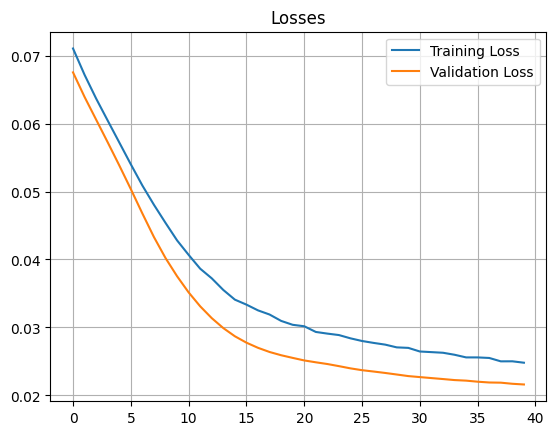

In [28]:
plt.grid()

plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label = "Training Loss")
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label = "Validation Loss")

plt.title("Losses")
plt.legend()

plt.show()

- Reconstruction error greater than one standard deviation from the normal training data can be considered as anomalous.

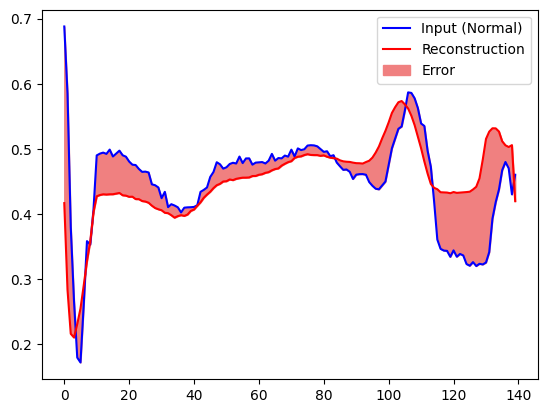

In [29]:
decoded_data = autoencoder(val_dataloader.dataset.tensors[0])

plt.plot(val_dataloader.dataset.tensors[0][0], 'b')
plt.plot(decoded_data[0].detach().numpy(), 'r')

plt.fill_between(np.arange(140), decoded_data[0].detach().numpy(), val_dataloader.dataset.tensors[0][0], color='lightcoral')

plt.legend(labels=["Input (Normal)", "Reconstruction", "Error"])
plt.show()


In [30]:
# decoded_data

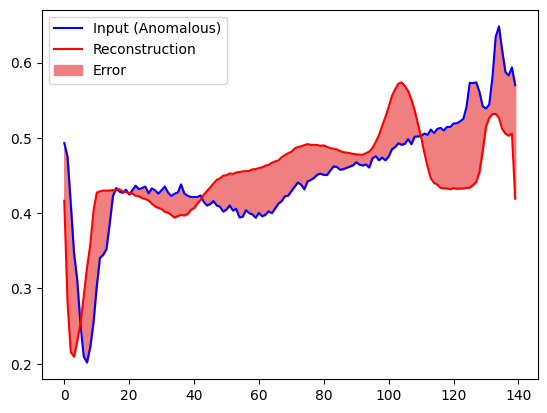

In [31]:
decoded_data = autoencoder(anomalous_test_data)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0].detach().numpy(), 'r')
plt.fill_between(np.arange(140), decoded_data[0].detach().numpy(), anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input (Anomalous)", "Reconstruction", "Error"])
plt.show()


### Evaluation

#### Detecting anomalies

- Anomalies can be detected by if the reconstruction error greater than a fixed threshold (one standard deviation).

In [32]:
criterion = nn.L1Loss()
loss_n = []

with torch.no_grad():
    model = autoencoder.eval()
    
    x = train_dataloader.dataset.tensors[0]

    for data in x:
        reconstructions = model(data)
        loss = criterion(reconstructions, data)

        loss_n.append(loss.item())    

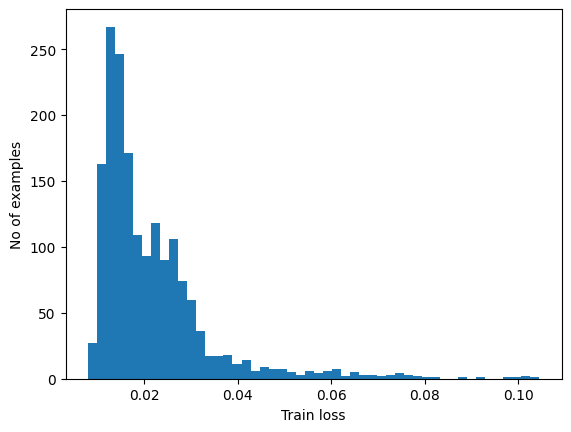

In [33]:
plt.hist(loss_n, bins = 50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [34]:
### calculate mean and standard deviation

threshold = np.mean(loss_n) + np.std(loss_n)
print("Threshold: ", threshold)

Threshold:  0.0338787006246262


In [35]:
criterion = nn.L1Loss()
loss_a = []

with torch.no_grad():
    model = autoencoder.eval()
    
    x = anomalous_test_data

    for data in x:
        reconstructions = model(data)
        loss = criterion(reconstructions, data)

        loss_a.append(loss.item())    

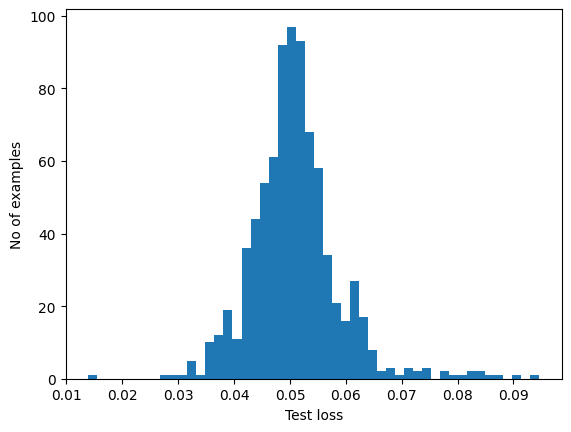

In [36]:
plt.hist(loss_a, bins = 50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

- Anomalous data have greater reconstruction error than the threshold.